# NEW CAPITAL ADMINISTRATION PRICE PREDICTION

## First Step : Webscraping of the data from the property finder website

In [49]:
import csv
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
from selenium.webdriver.chrome.service import Service


def get_properties(pages):
    print("Starting property scraping...")

    with open('properties.csv', 'w', newline='', encoding='utf-8-sig') as f:
        writer = csv.DictWriter(f, fieldnames=[
            'title', 'type', 'location', 'area_of_apt', 'no_of_bedrooms',
            'no_of_bathrooms', 'Amenities', 'price', 'link'
        ])
        writer.writeheader()
        print("CSV file created and header written.")

        chrome_options = Options()
        chrome_options.add_argument('--headless')
        driver = webdriver.Chrome(options=chrome_options)
        print("Headless Chrome driver initialized.")

        for page_num, page in enumerate(pages, start=1):
            print(f"\nFetching page {page_num}: {page}")
            response = requests.get(page)
            soup = BeautifulSoup(response.content, 'html.parser')

            all_properties = soup.findAll('article', attrs={'class': "property-card-module_property-card__wrapper__ZZTal"})
            print(f"Found {len(all_properties)} properties on page {page_num}")

            for idx, property in enumerate(all_properties, start=1):
                print(f"\nProcessing property #{idx} on page {page_num}...")
                try:
                    prop_title = property.find('h2', class_='styles-module_content__title__eOEkd').getText()
                    print(f"Title: {prop_title}")

                    prop_link = property.find('a', class_='property-card-module_property-card__link__L6AKb').get('href')
                    print(f"Link: {prop_link}")

                    prop_location = property.find('p', class_='styles-module_content__location__bNgNM').getText()
                    print(f"Location: {prop_location}")

                    prop_type = property.find('p', class_='styles-module_content__property-type__QuVl4').getText()
                    print(f"Type: {prop_type}")

                    prop_area = property.find('p', {'data-testid': 'property-card-spec-area'}).getText().split()[0]
                    print(f"Area: {prop_area} sqm")

                    prop_bedrooms = int(property.find('p', {'data-testid': 'property-card-spec-bedroom'}).getText().strip())
                    print(f"Bedrooms: {prop_bedrooms}")

                    prop_bathrooms = int(property.find('p', {'data-testid': 'property-card-spec-bathroom'}).getText().strip())
                    print(f"Bathrooms: {prop_bathrooms}")

                    price_text = property.find('p', {'data-testid': 'property-card-price'}).getText().strip()
                    price_number_str = price_text[:-4].replace(",", "")  # Remove " EGP" and commas
                    prop_price = int(price_number_str)
                    print(f"Price: {prop_price} EGP")

                    # Setup ChromeDriver
                    options = webdriver.ChromeOptions()
                    options.add_argument('--start-maximized')
                    driver2 = webdriver.Chrome(service=Service(), options=options)
                    url = prop_link
                    driver2.get(url)
                    driver2.execute_script("window.scrollTo(0, document.body.scrollHeight);")
                    time.sleep(3)
                    # Optional: click “Show more” if it exists
                    try:
                        show_more = WebDriverWait(driver2, 5).until(
                            EC.element_to_be_clickable((By.XPATH, "//button[contains(text(), 'Show more')]"))
                        )
                        show_more.click()
                        print("🟢 Clicked 'Show more'")
                        time.sleep(2)
                    except:
                        print("ℹ️ No 'Show more' button found.")

                    # Wait for amenities section
                    try:
                        WebDriverWait(driver2, 15).until(
                            EC.presence_of_element_located((By.CSS_SELECTOR, "div[data-testid^='amenity-']"))
                        )
                        print("✅ Amenities section loaded.")
                    except:
                        print("⛔ Timeout: Amenities did not load.")
                        driver2.quit()
                        exit()

                    # Parse page with BeautifulSoup
                    soup2 = BeautifulSoup(driver2.page_source, 'html.parser')
                    amenity_divs = soup2.find_all('div', attrs={'data-testid': lambda x: x and x.startswith('amenity-')})

                    # Extract text from amenities
                    amenities = [div.get_text(strip=True) for div in amenity_divs] if amenity_divs else ['Not found']
                    print(f"Amenities: {amenities}")

                    # Done
                    driver.quit()




                    

               
                    # Write to CSV
                    writer.writerow({
                        'title': prop_title,
                        'type': prop_type,
                        'location': prop_location,
                        'area_of_apt': prop_area,
                        'no_of_bedrooms': prop_bedrooms,
                        'no_of_bathrooms': prop_bathrooms,
                        'Amenities': amenities,
                        'price': prop_price,
                        'link': prop_link
                    })
                    print("Property written to CSV.")

                except Exception as e:
                    print(f"Error processing property #{idx} on page {page_num}: {e}")
        
        driver.quit()
        print("\nFinished scraping all pages. Chrome driver closed.")


print("All properties have been scraped and saved to properties.csv.")


All properties have been scraped and saved to properties.csv.


In [50]:
import pandas as pd

df= pd.read_csv(r"properties_ver01.csv")
df


,title,type,location,area_of_apt,no_of_bedrooms,no_of_bathrooms,Amenities,price,link
0,apartment for sale at Il Bosco attractive price,Apartment,"IL Bosco, New Capital Compounds, New Capital C...",192,4,4,"['Balcony', 'Shared Pool', 'Shared Spa', 'Secu...",6500000,https://www.propertyfinder.eg/en/plp/buy/apart...
1,Twin House at Il Bosco New Capital delivered,Twin House,"IL Bosco, New Capital Compounds, New Capital C...",247,4,5,"['Balcony', 'Private Garden', 'Shared Pool', '...",14000000,https://www.propertyfinder.eg/en/plp/buy/twin-...
2,Apartment in a prime location in R7,Apartment,"The City, New Capital Compounds, New Capital C...",163,3,3,"['Balcony', 'Shared Pool', 'Security', 'Lobby ...",8463367,https://www.propertyfinder.eg/en/plp/buy/apart...
3,own a prime location apartment at Green Avenue,Apartment,"Green Avenue, New Capital Compounds, New Capit...",168,3,3,"['Balcony', 'Shared Pool', 'Shared Spa', 'Secu...",3800000,https://www.propertyfinder.eg/en/plp/buy/apart...
4,apartment lowest price in Green Avenue delivered,Apartment,"Green Avenue, New Capital Compounds, New Capit...",158,3,3,"['Balcony', 'Shared Pool', 'Shared Spa', 'Secu...",3400000,https://www.propertyfinder.eg/en/plp/buy/apart...
...,...,...,...,...,...,...,...,...,...
2740,Apartment RTM At Launch Price in R3 Over 12 Years,Apartment,"Al Maqsad, New Capital Compounds, New Capital ...",170,2,2,"['Study', 'Central A/C', 'Balcony', 'Private G...",11000000,https://www.propertyfinder.eg/en/plp/buy/apart...
2741,Apartment 120m RTM Finished At Launch Over12Years,Apartment,"Al Maqsad, New Capital Compounds, New Capital ...",120,1,1,"['Study', 'Central A/C', 'Balcony', 'Private G...",7800000,https://www.propertyfinder.eg/en/plp/buy/apart...
2742,Apartment 160m Finished RTM in R3 Over 10 Years,Apartment,"Al Maqsad, New Capital Compounds, New Capital ...",160,2,2,"['Study', 'Central A/C', 'Balcony', 'Private G...",10400000,https://www.propertyfinder.eg/en/plp/buy/apart...
2743,Apartment Ready to move At Launch Over 10Y in R3,Apartment,"Al Maqsad, New Capital Compounds, New Capital ...",150,2,2,"['Study', 'Central A/C', 'Balcony', 'Private G...",9750000,https://www.propertyfinder.eg/en/plp/buy/apart...


In [51]:
df= df.drop_duplicates()

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [52]:
df.isnull().sum()


title              0
type               0
location           0
area_of_apt        0
no_of_bedrooms     0
no_of_bathrooms    0
Amenities          0
price              0
link               0
dtype: int64

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2708 entries, 0 to 2744
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            2708 non-null   object
 1   type             2708 non-null   object
 2   location         2708 non-null   object
 3   area_of_apt      2708 non-null   object
 4   no_of_bedrooms   2708 non-null   int64 
 5   no_of_bathrooms  2708 non-null   int64 
 6   Amenities        2708 non-null   object
 7   price            2708 non-null   int64 
 8   link             2708 non-null   object
dtypes: int64(3), object(6)
memory usage: 211.6+ KB


In [54]:
df.duplicated().sum()

np.int64(0)

In [55]:
df.drop(columns=['link'], inplace=True)
df.drop(columns=['title'], inplace=True)

C:\Users\ahmed\AppData\Local\Temp\ipykernel_6160\3930539252.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['link'], inplace=True)
C:\Users\ahmed\AppData\Local\Temp\ipykernel_6160\3930539252.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['title'], inplace=True)


In [56]:
df

,type,location,area_of_apt,no_of_bedrooms,no_of_bathrooms,Amenities,price
0,Apartment,"IL Bosco, New Capital Compounds, New Capital C...",192,4,4,"['Balcony', 'Shared Pool', 'Shared Spa', 'Secu...",6500000
1,Twin House,"IL Bosco, New Capital Compounds, New Capital C...",247,4,5,"['Balcony', 'Private Garden', 'Shared Pool', '...",14000000
2,Apartment,"The City, New Capital Compounds, New Capital C...",163,3,3,"['Balcony', 'Shared Pool', 'Security', 'Lobby ...",8463367
3,Apartment,"Green Avenue, New Capital Compounds, New Capit...",168,3,3,"['Balcony', 'Shared Pool', 'Shared Spa', 'Secu...",3800000
4,Apartment,"Green Avenue, New Capital Compounds, New Capit...",158,3,3,"['Balcony', 'Shared Pool', 'Shared Spa', 'Secu...",3400000
...,...,...,...,...,...,...,...
2740,Apartment,"Al Maqsad, New Capital Compounds, New Capital ...",170,2,2,"['Study', 'Central A/C', 'Balcony', 'Private G...",11000000
2741,Apartment,"Al Maqsad, New Capital Compounds, New Capital ...",120,1,1,"['Study', 'Central A/C', 'Balcony', 'Private G...",7800000
2742,Apartment,"Al Maqsad, New Capital Compounds, New Capital ...",160,2,2,"['Study', 'Central A/C', 'Balcony', 'Private G...",10400000
2743,Apartment,"Al Maqsad, New Capital Compounds, New Capital ...",150,2,2,"['Study', 'Central A/C', 'Balcony', 'Private G...",9750000


In [57]:
df["location"] = df["location"].str.split(",").str[0]

C:\Users\ahmed\AppData\Local\Temp\ipykernel_6160\2743658108.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["location"] = df["location"].str.split(",").str[0]


In [58]:
df

,type,location,area_of_apt,no_of_bedrooms,no_of_bathrooms,Amenities,price
0,Apartment,IL Bosco,192,4,4,"['Balcony', 'Shared Pool', 'Shared Spa', 'Secu...",6500000
1,Twin House,IL Bosco,247,4,5,"['Balcony', 'Private Garden', 'Shared Pool', '...",14000000
2,Apartment,The City,163,3,3,"['Balcony', 'Shared Pool', 'Security', 'Lobby ...",8463367
3,Apartment,Green Avenue,168,3,3,"['Balcony', 'Shared Pool', 'Shared Spa', 'Secu...",3800000
4,Apartment,Green Avenue,158,3,3,"['Balcony', 'Shared Pool', 'Shared Spa', 'Secu...",3400000
...,...,...,...,...,...,...,...
2740,Apartment,Al Maqsad,170,2,2,"['Study', 'Central A/C', 'Balcony', 'Private G...",11000000
2741,Apartment,Al Maqsad,120,1,1,"['Study', 'Central A/C', 'Balcony', 'Private G...",7800000
2742,Apartment,Al Maqsad,160,2,2,"['Study', 'Central A/C', 'Balcony', 'Private G...",10400000
2743,Apartment,Al Maqsad,150,2,2,"['Study', 'Central A/C', 'Balcony', 'Private G...",9750000


In [59]:
import ast
df["Amenities"] = df["Amenities"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

from itertools import chain
all_amenities = list(set(chain.from_iterable(df["Amenities"])))
all_amenities


C:\Users\ahmed\AppData\Local\Temp\ipykernel_6160\628169859.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Amenities"] = df["Amenities"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


['Shared Pool',
 'Shared Gym',
 'Lobby in Building',
 'View of Water',
 'Private Pool',
 'Balcony',
 'Security',
 'Walk-in Closet',
 "Children's Pool",
 'Study',
 'Central A/C',
 'Maids Room',
 'Private Garden',
 'Built in Wardrobes',
 'Shared Spa',
 'View of Landmark',
 'Kitchen Appliances',
 'Covered Parking']

In [60]:

common_amenities = ['Shared Pool',
 'Shared Spa',
 'Walk-in Closet',
 'View of Water',
 "Children's Pool",
 'Private Pool',
 'Covered Parking',
 'Security',
 'Lobby in Building',
 'View of Landmark',
 'Study',
 'Central A/C',
 'Maids Room',
 'Private Garden',
 'Built in Wardrobes',
 'Kitchen Appliances',
 'Shared Gym',
 'Balcony']

for amenity in common_amenities:
    col_name = f'has_{amenity.lower().replace(" ", "_").replace("/", "").replace("-", "_")}'
    df[col_name] = df['Amenities'].apply(lambda x: int(amenity in x) if isinstance(x, list) else 0)



C:\Users\ahmed\AppData\Local\Temp\ipykernel_6160\1001052224.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_name] = df['Amenities'].apply(lambda x: int(amenity in x) if isinstance(x, list) else 0)
C:\Users\ahmed\AppData\Local\Temp\ipykernel_6160\1001052224.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_name] = df['Amenities'].apply(lambda x: int(amenity in x) if isinstance(x, list) else 0)
C:\Users\ahmed\AppData\Local\Temp\ipykernel_6160\1001052224.py:22: SettingWithCopyWarning: 
A 

In [61]:
df.drop(columns=['Amenities'], inplace=True)

C:\Users\ahmed\AppData\Local\Temp\ipykernel_6160\3039023176.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['Amenities'], inplace=True)


In [62]:
df

,type,location,area_of_apt,no_of_bedrooms,no_of_bathrooms,price,has_shared_pool,has_shared_spa,has_walk_in_closet,has_view_of_water,...,has_lobby_in_building,has_view_of_landmark,has_study,has_central_ac,has_maids_room,has_private_garden,has_built_in_wardrobes,has_kitchen_appliances,has_shared_gym,has_balcony
0,Apartment,IL Bosco,192,4,4,6500000,1,1,0,0,...,1,1,0,0,0,0,0,0,1,1
1,Twin House,IL Bosco,247,4,5,14000000,1,1,0,0,...,1,1,0,0,0,1,0,0,1,1
2,Apartment,The City,163,3,3,8463367,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,Apartment,Green Avenue,168,3,3,3800000,1,1,0,0,...,1,1,0,0,0,0,0,0,1,1
4,Apartment,Green Avenue,158,3,3,3400000,1,1,0,0,...,1,1,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2740,Apartment,Al Maqsad,170,2,2,11000000,1,1,0,0,...,0,0,1,1,0,1,1,0,0,1
2741,Apartment,Al Maqsad,120,1,1,7800000,1,1,0,0,...,0,0,1,1,0,1,1,0,0,1
2742,Apartment,Al Maqsad,160,2,2,10400000,1,1,0,0,...,0,0,1,1,0,1,1,0,0,1
2743,Apartment,Al Maqsad,150,2,2,9750000,1,1,0,0,...,0,0,1,1,0,1,1,0,0,1


In [63]:
df['area_of_apt'] = df['area_of_apt'].astype(str).str.replace(",", "", regex=False)
df['area_of_apt'] = pd.to_numeric(df['area_of_apt'], errors='coerce').astype('Int64')


C:\Users\ahmed\AppData\Local\Temp\ipykernel_6160\4026799126.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['area_of_apt'] = df['area_of_apt'].astype(str).str.replace(",", "", regex=False)
C:\Users\ahmed\AppData\Local\Temp\ipykernel_6160\4026799126.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['area_of_apt'] = pd.to_numeric(df['area_of_apt'], errors='coerce').astype('Int64')


In [64]:
df["price_per_sqm"] = df['price'] / df["area_of_apt"]
df["price_per_sqm"] = df["price_per_sqm"].astype("Int64") 


C:\Users\ahmed\AppData\Local\Temp\ipykernel_6160\2583956158.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["price_per_sqm"] = df['price'] / df["area_of_apt"]
C:\Users\ahmed\AppData\Local\Temp\ipykernel_6160\2583956158.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["price_per_sqm"] = df["price_per_sqm"].astype("Int64")


In [65]:
df = pd.get_dummies(df, columns=["type", "location"], drop_first=False)


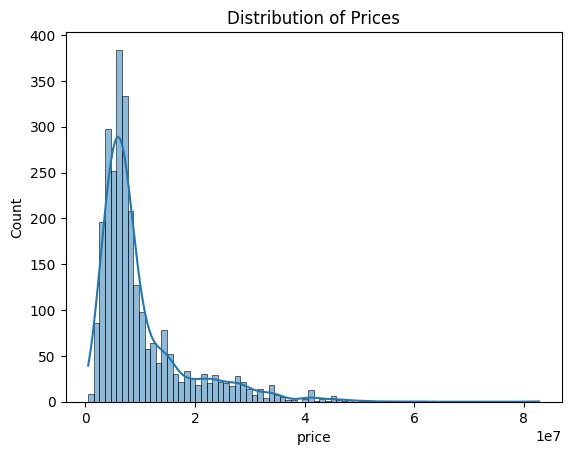

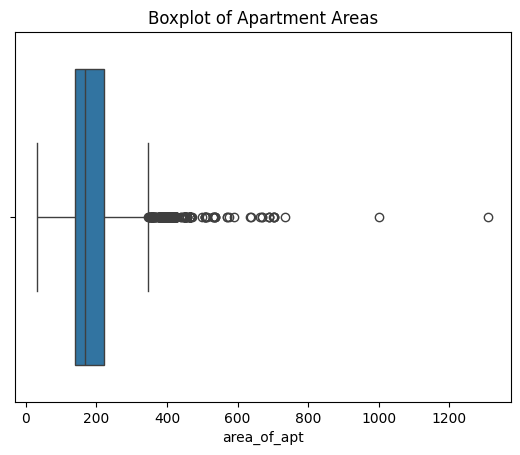

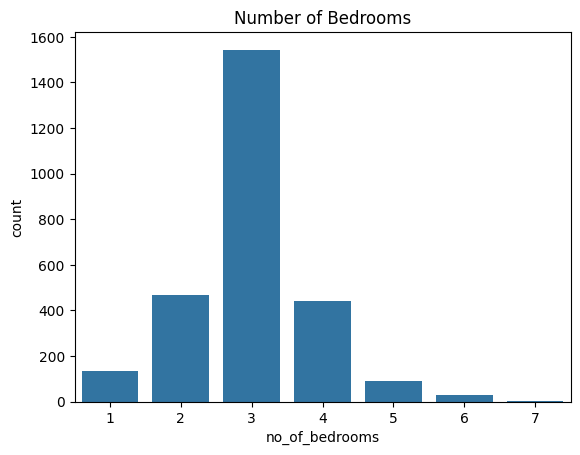

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

# Histogram for price
sns.histplot(df['price'], bins=80, kde=True)
plt.title('Distribution of Prices')
plt.show()

# Boxplot for area
sns.boxplot(x=df['area_of_apt'])
plt.title('Boxplot of Apartment Areas')
plt.show()

# Bar plot for number of bedrooms
sns.countplot(x='no_of_bedrooms', data=df)
plt.title('Number of Bedrooms')
plt.show()


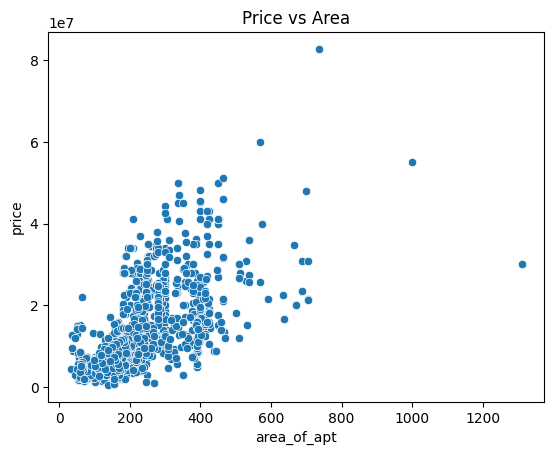

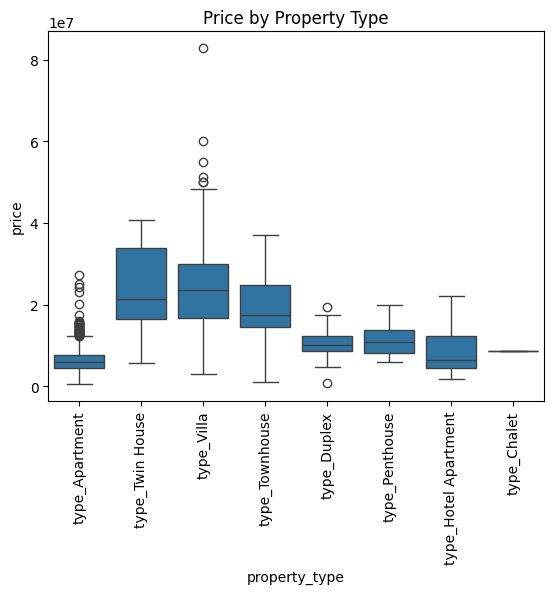

In [67]:
sns.scatterplot(x='area_of_apt', y='price', data=df)
plt.title('Price vs Area')
plt.show()


df['property_type'] = df[[col for col in df.columns if col.startswith('type_')]].idxmax(axis=1)
sns.boxplot(x='property_type', y='price', data=df)
plt.xticks(rotation=90)
plt.title('Price by Property Type')
plt.show()


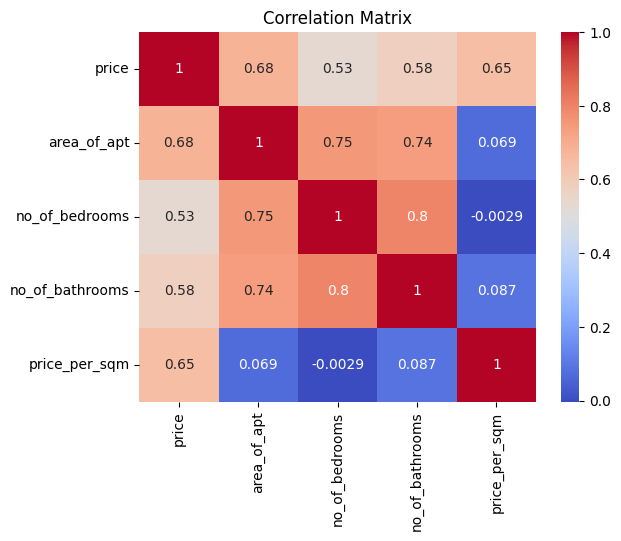

In [68]:
import numpy as np
corr = df[['price', 'area_of_apt', 'no_of_bedrooms', 'no_of_bathrooms', 'price_per_sqm']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [69]:
# removing outlier 

df = df[df['price'] != 531000000]


In [70]:
df = df[df['price'] >= 5_000_000]

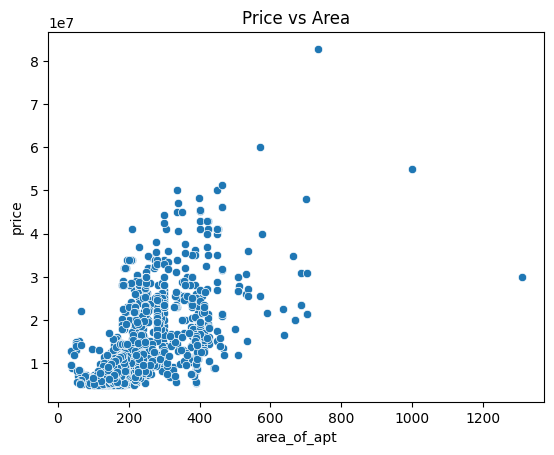

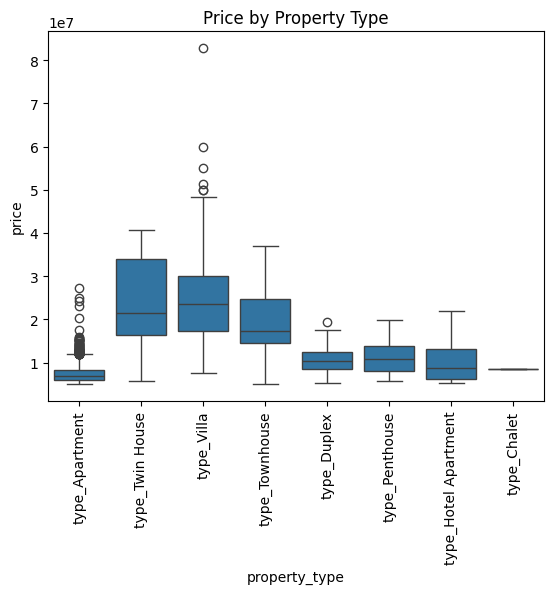

In [71]:
sns.scatterplot(x='area_of_apt', y='price', data=df)
plt.title('Price vs Area')
plt.show()


df['property_type'] = df[[col for col in df.columns if col.startswith('type_')]].idxmax(axis=1)
sns.boxplot(x='property_type', y='price', data=df)
plt.xticks(rotation=90)
plt.title('Price by Property Type')
plt.show()


In [72]:
df['price'].describe()

count    2.043000e+03
mean     1.203107e+07
std      8.556778e+06
min      5.000000e+06
25%      6.500000e+06
50%      8.300000e+06
75%      1.450000e+07
max      8.280000e+07
Name: price, dtype: float64

In [73]:
df['no_of_bedrooms'].value_counts()

no_of_bedrooms
3    1148
4     434
2     288
5      91
1      53
6      26
7       3
Name: count, dtype: int64

In [74]:
df = df.applymap(lambda x: 1 if x == True else (0 if x == False else x))

C:\Users\ahmed\AppData\Local\Temp\ipykernel_6160\583116288.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if x == True else (0 if x == False else x))


In [75]:
df

,area_of_apt,no_of_bedrooms,no_of_bathrooms,price,has_shared_pool,has_shared_spa,has_walk_in_closet,has_view_of_water,has_children's_pool,has_private_pool,...,location_The City Valley,location_The Curve,location_The Islands,location_The Loft,location_Tonino Lamborghini - ATIKA Residence,location_Town Gate,location_Vinci,location_Yaru new capital Compound,location_il Mondo,property_type
0,192,4,4,6500000,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,type_Apartment
1,247,4,5,14000000,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,type_Twin House
2,163,3,3,8463367,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,type_Apartment
5,221,4,4,7677761,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,type_Apartment
8,280,4,4,23000000,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,type_Twin House
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2740,170,2,2,11000000,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,type_Apartment
2741,120,1,1,7800000,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,type_Apartment
2742,160,2,2,10400000,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,type_Apartment
2743,150,2,2,9750000,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,type_Apartment


In [76]:
df.drop(columns=['property_type'], inplace=True)

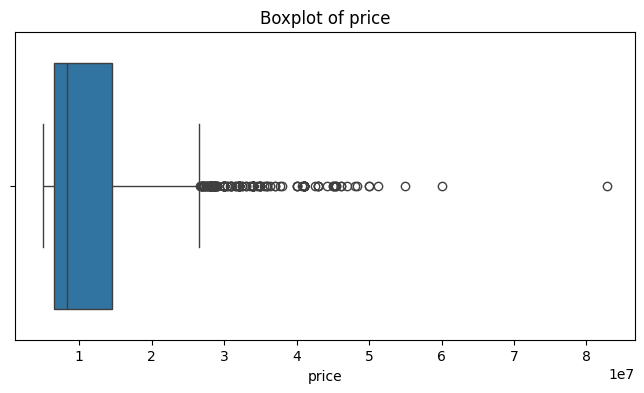

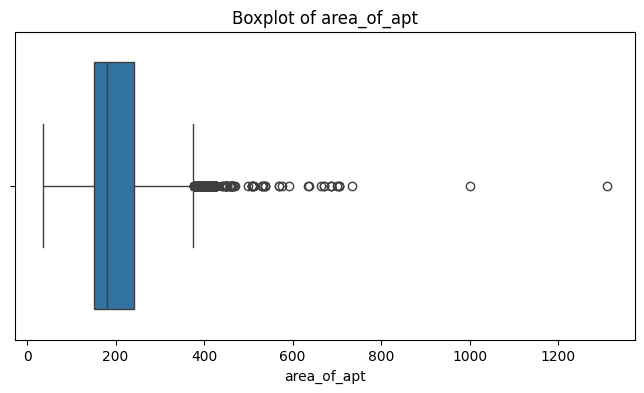

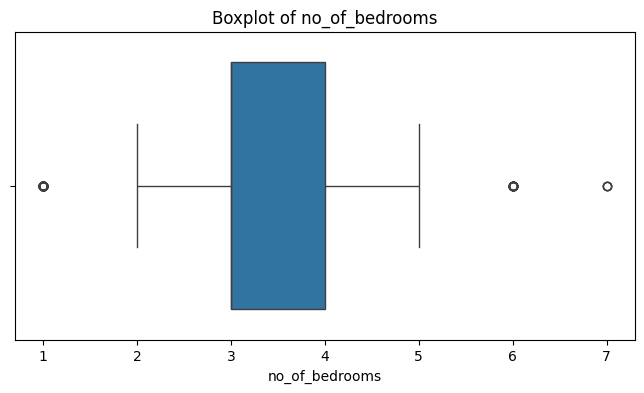

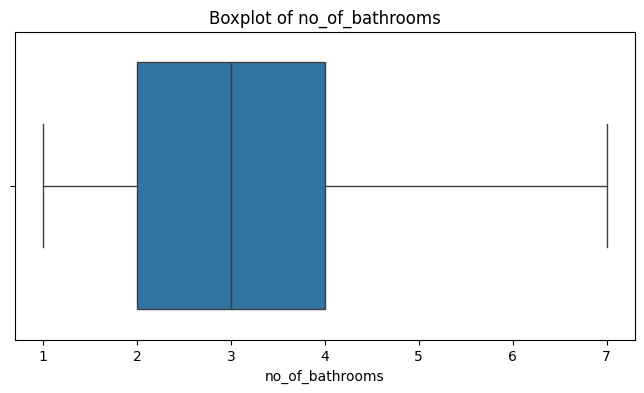

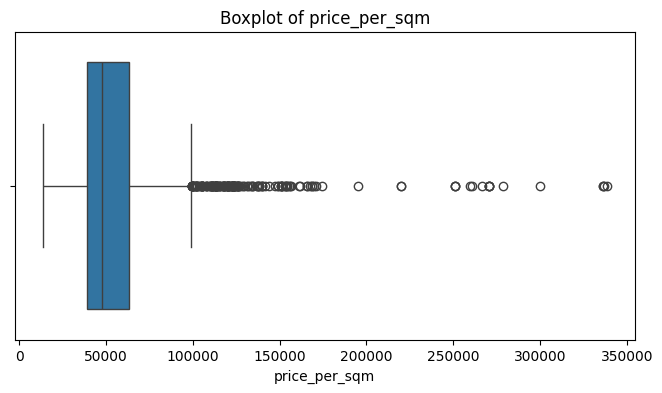

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of continuous numerical columns
numerical_cols = ['price', 'area_of_apt', 'no_of_bedrooms', 'no_of_bathrooms', 'price_per_sqm']

for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()


In [78]:
correlation = df.corr()['price'].abs().sort_values(ascending=False)
top_features = correlation[1:11]  # top 10 correlated features with price
print(top_features)


type_Apartment            0.698539
area_of_apt               0.639249
type_Villa                0.586376
price_per_sqm             0.585030
no_of_bathrooms           0.541096
location_La Vista City    0.524988
no_of_bedrooms            0.511912
type_Townhouse            0.312850
type_Twin House           0.257705
location_Granville        0.243454
Name: price, dtype: float64


In [99]:

avg_meter_price = 57117.58

df['avg_meter_price'] = df['area_of_apt'] * avg_meter_price

# Split the data
X = df.drop(columns=['price'])
y = df['price']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [100]:
#Linear Regrission:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

r2_lr


0.8703193344701604

In [101]:
#random forest :

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

r2_rf


0.9865683498404982

In [102]:
#desicion tree :
from sklearn.tree import DecisionTreeRegressor


dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

r2_dt


0.9651124216517901

In [103]:
print("Model Comparison:")
print(f"Linear Regression:     MSE = {mse_lr:.2f}, R² = {r2_lr:.4f}")
print(f"Random Forest:         MSE = {mse_rf:.2f}, R² = {r2_rf:.4f}")
print(f"Desicion Tree Regressor:     MSE = {mse_dt:.2f}, R² = {r2_dt:.4f}")


Model Comparison:
Linear Regression:     MSE = 9268382595320.81, R² = 0.8703
Random Forest:         MSE = 959970956781.67, R² = 0.9866
Desicion Tree Regressor:     MSE = 2493443588019.19, R² = 0.9651


In [104]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, scoring='r2', n_jobs=-1)

grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_


In [105]:
import joblib

# Save the trained model
joblib.dump(best_rf, "model.pkl")

# Save the features (column names used in training)
joblib.dump(X.columns.tolist(), "features.pkl")

print("✅ Model and feature list saved as 'modell.pkl' and 'features.pkl'")


✅ Model and feature list saved as 'modell.pkl' and 'features.pkl'


In [106]:
df.to_csv("properties_final.csv", index=False)